# Identify Alleles with Cell Count Differences

In [1]:
# Imports
import os
import warnings
import numpy as np
import polars as pl
import pandas as pd
from tqdm import tqdm
import statsmodels.formula.api as smf
from scipy.stats import ttest_rel, ttest_ind
from plot_utils import *

PLATEMAP_DIR = "../2.snakemake_pipeline/inputs/metadata/platemaps/{batch_id}/platemap"
PROF_DIR = "../2.snakemake_pipeline/outputs/batch_profiles"
CLASS_RES_DIR = "../2.snakemake_pipeline/outputs/classification_analyses"
IMG_QC_DIR = "../../../../3_outputs/1_snakemake_pipeline/2.smp_results_analyses/1.image_qc_outputs/{bio_rep}"

In [2]:
BIO_REP_BATCHES_DICT = {
    "2024_01_Batch_7-8": ("2024_01_23_Batch_7", "2024_02_06_Batch_8"),
    "2024_12_Batch_11-12": ("2024_12_09_Batch_11", "2024_12_09_Batch_12"),
    "2025_03_Batch_15-16": ("2025_03_17_Batch_15", "2025_03_17_Batch_16"),
    # "2025_01_Batch_13-14": ("2025_01_27_Batch_13", "2025_01_28_Batch_14")
}

BIO_BATCH_MAP_DICT = {
    "B7": "B_7-8",
    "B8": "B_7-8",
    "B11": "B_11-12",
    "B12": "B_11-12",
    "B15": "B_15-16",
    "B16": "B_15-16",
}

CLASS_RES_OUTDIR = "../../../../3_outputs/1_snakemake_pipeline/2.smp_results_analyses/2.cell_count_abundance_change"

## 1. Summarize Cell Count Profiles

### 1.1 Allele Metadata

In [3]:
allele_meta_df = pl.DataFrame()
allele_meta_df_dict, img_well_qc_sum_dict = {}, {}

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        allele_meta_df_batch = pl.DataFrame()
        platemaps = [file for file in os.listdir(PLATEMAP_DIR.format(batch_id=batch_id)) if file.endswith(".txt")]
        for platemap in platemaps:
            platemap_df = pl.read_csv(os.path.join(PLATEMAP_DIR.format(batch_id=batch_id), platemap), separator="\t", infer_schema_length=100000)
            allele_meta_df_batch = pl.concat([allele_meta_df_batch, 
                                        platemap_df.filter((pl.col("node_type").is_not_null()))], # (~pl.col("node_type").is_in(["TC","NC","PC"]))&
                                        how="diagonal_relaxed").sort("plate_map_name")
            allele_meta_df_batch = allele_meta_df_batch.with_columns(pl.col("plate_map_name").alias("plate_map")) ## str.split('_').list.get(0).
        allele_meta_df = pl.concat([
            allele_meta_df,
            allele_meta_df_batch
        ], how="diagonal_relaxed")#.sort("plate_map_name") ## (~pl.col("node_type").is_in(["TC","NC","PC"]))&
    allele_meta_df_dict[bio_rep] = allele_meta_df_batch

    img_well_qc_sum = pl.read_csv(f"{IMG_QC_DIR.format(bio_rep=bio_rep)}/plate-well-level_img_qc_sum.csv")
    img_well_qc_sum = img_well_qc_sum.with_columns(
        pl.col("channel").replace("DAPI", "DNA").alias("channel")
    )
    img_well_qc_sum_morph = img_well_qc_sum.filter(pl.col("channel")!="GFP")
    img_well_qc_sum_morph = img_well_qc_sum_morph.group_by(["plate","well"]).agg(
        pl.col("is_bg").max().alias("is_bg"),
        pl.col("s2n_ratio").mean().alias("s2n_ratio")
    ).with_columns(pl.lit("Morph").alias("channel"))
    img_well_qc_sum = pl.concat([
        img_well_qc_sum.select(pl.col(["plate","well","channel","is_bg","s2n_ratio"])),
        img_well_qc_sum_morph.select(pl.col(["plate","well","channel","is_bg","s2n_ratio"])),
    ], how="vertical_relaxed")
    img_well_qc_sum_dict[bio_rep] = img_well_qc_sum

In [4]:
tested_variants = allele_meta_df.filter((pl.col("gene_allele").is_not_null())&(pl.col("node_type")=="allele")).unique(subset=["gene_allele"])["gene_allele"]
len(tested_variants)

865

### 1.2 Cell Count Profiles

In [5]:
well_profiles = pl.DataFrame()

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    combined_profiles_batch = pl.DataFrame()
    for batch_id in bio_rep_batches:
        batch_alleles = (
            pl.scan_parquet(
                f"{PROF_DIR}/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet"
            )
            .select([
                "Metadata_gene_allele",
                "Metadata_Well",
                "Metadata_Plate",
            ])
        )
        combined_profiles_batch = pl.concat([combined_profiles_batch, batch_alleles.collect()])
    
    ## Get the cell count per allele in each well
    well_profiles_batch = combined_profiles_batch.group_by([
        "Metadata_Well", "Metadata_Plate", "Metadata_gene_allele"
    ]).len().rename({"len": "Cell_count"})
    # print(well_profiles_batch.filter(pl.col("Metadata_gene_allele").str.contains("_")).unique(subset="Metadata_gene_allele"))
    
    img_well_qc_sum = pl.read_csv(f"{IMG_QC_DIR.format(bio_rep=bio_rep)}/plate-well-level_img_qc_sum.csv")
    img_well_qc_sum_dapi = img_well_qc_sum.filter(pl.col("channel")=="DAPI").with_columns(
        pl.col("plate").alias("Metadata_Plate"),
        pl.col("well").alias("Metadata_Well"),
    )
    ## Filter other channels
    # img_well_qc_sum_mito = img_well_qc_sum.filter(pl.col("channel")=="Mito").with_columns(
    #     pl.col("plate").alias("Metadata_Plate"),
    #     pl.col("well").alias("Metadata_Well"),
    # )
    well_profiles_batch = well_profiles_batch.join(
        img_well_qc_sum_dapi,
        on=["Metadata_Plate","Metadata_Well"],
        how="left"
    ).select(
        pl.col(["Metadata_Plate","Metadata_Well","Metadata_gene_allele","Cell_count","is_bg"])
    ).with_columns(
        pl.col("Metadata_Plate").str.extract(r"(B[^A]*)", 1).replace(BIO_BATCH_MAP_DICT).alias("Metadata_Bio_Batch")
    ).rename({"is_bg": "dna_is_bg"})
    # print(well_profiles_batch.filter(pl.col("Metadata_gene_allele").str.contains("_")).unique(subset="Metadata_gene_allele"))
    well_profiles = pl.concat([well_profiles, well_profiles_batch])

print("Original image wells:", well_profiles.shape[0])

Original image wells: 11788


In [6]:
# def plot_cc_per_plate(well_profile_df):
#     plate_maps = sorted(set(["_".join(plate_map.split("_")[:-1]) for plate_map in sorted(well_profile_df["Metadata_Plate"].unique())]))
#     # print(plate_maps)
#     for plate_map in plate_maps:
#         if (plate_map != "2024_01_17_B7A1R1"):
#             continue
#         plate_map_cc = well_profile_df.filter(pl.col("Metadata_Plate").str.contains(plate_map))
#         plates = sorted(plate_map_cc["Metadata_Plate"].unique().to_list())
#         print(plates)
#         fig, axes = plt.subplots(2,2,figsize=(48,23)) ## sharey=True,sharex=True
#         for plate in plates:
#             plate_info = plate_map_cc.filter(pl.col("Metadata_Plate")==plate)
#             # display(plate_info.filter(pl.col("is_bg")))
#             # print(plates.index(plate))
#             plot_platemap(
#                 plate_info,
#                 plate,
#                 well_pos_col="Metadata_Well",
#                 # this is the column to color by (categorical or continuous)
#                 value_col="Cell_count",
#                 # these columns will be concatenated into the annotation text
#                 label_cols=("Metadata_gene_allele","Cell_count"),
#                 ax=axes[plates.index(plate)//2, plates.index(plate)%2],
#                 value_type="continuous",   # or "continuous"
#                 continuous_cmap="vlag",  # matplotlib colormap for continuous mode
#                 grid_square=None
#             )
#         fig.subplots_adjust(wspace=-.55, hspace=.05)
#         plt.tight_layout()
#         plt.show()
#         # break

# plot_cc_per_plate(well_profiles)

In [7]:
well_profiles = well_profiles.filter(~pl.col("dna_is_bg"))
print("Image wells after QC based on DAPI:", well_profiles.shape[0])

Image wells after QC based on DAPI: 10895


In [11]:
# batch_log_files = [
#     f"{CLASS_RES_DIR}/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/classify.log" \
#     for batch_id in BIO_REP_BATCHES
# ]
# dropped_well_df = pl.DataFrame()
# for logfile in batch_log_files:
#     with open(logfile, encoding="latin-1") as f:
#         lines = f.readlines()
#     dropped_wells = [(l.split(",")[0].strip(), l.split(",")[1].strip()) for l in lines if l.startswith("2025")]
#     dropped_well_df = pl.concat([dropped_well_df, 
#                                  pl.DataFrame({"plate": [well[0] for well in dropped_wells],
#                                                "imaging_well": [well[1].split(":")[0] for well in dropped_wells],
#                                                "gene_allele": [well[1].split(":")[1] for well in dropped_wells]})])
# # dropped_well_df.filter(pl.col("gene_allele").is_in(img_well_qc_sum_dapi.filter(pl.col("is_bg"))["gene_allele"].unique()))

## 2. Cell Count Change Detection

### 2.1 Paired T-test

In [9]:
from scipy.stats import shapiro
import re
from scipy.stats import wilcoxon
from scipy.stats import ttest_rel
import pandas as pd


# Convert letter rows to numbers
def well_to_coordinates(well):
    row_letter, col_number = re.match(r"([A-P])(\d{2})", well).groups()
    row_index = ord(row_letter) - ord('A') + 1  # Convert 'A'->1, 'B'->2, ..., 'P'->16
    col_index = int(col_number)  # Convert string column to integer
    return well, row_index, col_index


# Compute distances from edges and find the most centered well
def compute_distance(row, col):
    return min(row - 1, 16 - row, col - 1, 24 - col)  # Distance from nearest edge
    

def paired_ttest(dat, reference: str, var: str):
    ## perform stat test
    ## sorted the two alleles to make sure they are from the same plate for paired t-test    
    # if (dat[dat["Metadata_gene_allele"]==reference].shape[0] != dat[dat["Metadata_gene_allele"]==var].shape[0]):
    # pivot to wide: one row per plate
    wide_cc = dat.pivot(index="Metadata_Plate",
                        columns="Metadata_gene_allele",
                        values="Cell_count")
    # print(wide_cc)
    # drop any plate that doesn’t have both measurements
    wide_cc = wide_cc.dropna(subset=[reference, var])
    if wide_cc.shape[0] >= 2:
        # now run paired t-test
        t_stat, p_val = ttest_rel(wide_cc[reference], wide_cc[var])
    else:
        t_stat, p_val = None, None

    # df_sampled["PlateID"] = df_sampled["Metadata_Plate"].str.extract(r"(P\d+T\d+)", expand=False)
    
    ## adjust for edge effect
    # dat["dist2edge"] = dat["Metadata_Well"].apply(lambda x: compute_distance(well_to_coordinates(x)[1], well_to_coordinates(x)[2]))
    # fit Cell_count ~ dist2edge
    # m0 = smf.ols("Cell_count ~ dist2edge", data=dat).fit()
    # dat["resid"] = m0.resid
    # ## calc t-test on residuals corrected for distance to edge
    # wide_res = dat.pivot(index="Metadata_Plate",
    #                     columns="Metadata_gene_allele",
    #                     values="resid")
    # # drop any plate that doesn’t have both measurements
    # wide_res = wide_res.dropna(subset=[reference, var])
    # if wide_res.shape[0] >= 3:
    #     # now run paired t-test
    #     res_t_stat, res_p_val = ttest_rel(wide_res[reference], wide_res[var])
    # else:
    #     res_t_stat, res_p_val = None, None
    
    summary_df = pl.DataFrame(
        {
            "t_stat": t_stat,
            "p_val": p_val,
            # "t_stat_res": res_t_stat,
            # "p_val_res": res_p_val
        }
    )
    summary_df = summary_df.with_columns(
        pl.lit(reference).alias("Gene"), pl.lit(var).alias("Variant")
    )
    return summary_df


def ind_ttest(dat, reference: str, var: str):
    ## Per each ref-var well pair on the SAME plate, train and test the classifier
    ## sort the wells to make sure they are from the same plate
    df_sampled = pd.DataFrame()
    for plate in dat["Metadata_Plate"].unique():
        dat = dat[dat["Metadata_Plate"]==plate].dropna().sort_values(["Metadata_gene_allele"])
        # count rows per group
        group_counts = dat.groupby("Metadata_gene_allele").size()
        min_count = group_counts.min()
        # print("Minimum rows in any group:", min_count)
        shuffled = dat.sample(frac=1, random_state=42).reset_index(drop=True)
        # Then take the first min_count rows per group
        sampled_df2 = (
            shuffled
            .groupby("Metadata_gene_allele", group_keys=False)
            .head(min_count)
        )
        df_sampled = pd.concat([df_sampled, sampled_df2])

    # m0 = smf.ols("Cell_count ~ Metadata_Well", data=df_sampled).fit()
    # df_sampled["resid"] = m0.resid
    # print(df_sampled)
    ## require at least two alleles per each VAR and WT group
    if df_sampled.shape[0] >= 4:
        # now run paired t-test
        t_stat, p_val = ttest_ind(df_sampled.loc[df_sampled["Metadata_gene_allele"]==reference, "Cell_count"].values, 
                                  df_sampled.loc[df_sampled["Metadata_gene_allele"]==allele, "Cell_count"].values,
                                  equal_var=False)
        # res_t_stat, res_p_val = ttest_ind(df_sampled.loc[df_sampled["Metadata_gene_allele"]==reference, "resid"].values, 
        #                                   df_sampled.loc[df_sampled["Metadata_gene_allele"]==allele, "resid"].values,
        #                                   equal_var=False)
    else:
        t_stat, p_val = None, None
        # res_t_stat, res_p_val = None, None
        
    # break
    summary_df = pl.DataFrame(
        {
            "t_stat": t_stat,
            "p_val": p_val,
            # "t_stat_res": res_t_stat,
            # "p_val_res": res_p_val
        }
    )
    summary_df = summary_df.with_columns(
        pl.lit(reference).alias("Gene"), pl.lit(var).alias("Variant")
    )
    return summary_df

In [10]:
well_cc_stats = []

for allele in tqdm(well_profiles.select(pl.col("Metadata_gene_allele")).to_pandas()["Metadata_gene_allele"].unique()):
    if allele is None or allele.split("_")[0] == allele or allele not in tested_variants:
        continue

    reference = allele.split("_")[0]
    temp_prof_var = well_profiles.filter(
        (pl.col("Metadata_gene_allele") == allele) | (pl.col("Metadata_gene_allele") == reference)
    ).select(
        pl.col(["Metadata_gene_allele","Metadata_Plate","Metadata_Well","Metadata_Bio_Batch","Cell_count"])
    ).to_pandas()

    bio_batch_list = list(temp_prof_var["Metadata_Bio_Batch"].unique())
    # if (len(bio_batch_list) > 1):
    #     print(bio_batch_list)
    #     print(allele)
        # print(temp_prof_var)
    for bio_batch in bio_batch_list:
        temp_prof = temp_prof_var[temp_prof_var["Metadata_Bio_Batch"]==bio_batch]
        if (temp_prof["Metadata_gene_allele"].unique().shape[0] < 2):
            # print(temp_prof)
            continue
            
        var_profiles = temp_prof[temp_prof["Metadata_gene_allele"]==allele]
        ref_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==reference)&(temp_prof["Metadata_Plate"].isin(var_profiles["Metadata_Plate"].unique()))]
        temp_prof = pd.concat([var_profiles, ref_profiles])
        # if allele == "DES_Ser46Tyr":
        #     display(temp_prof)
        
        # print(batch_plate)
        ## Select ONLY the wells most distant from the edge per each allele to minimize the well-position edge effects
        ## deprecated: let's compare every pair
        # if (ref_profiles.shape[0] > var_profiles.shape[0]):
        #     ref_al_wells = ref_profiles["Metadata_Well"].unique()
        #     well_coords = [well_to_coordinates(w) for w in set([ref_well_pl for ref_well_pl in ref_al_wells])]
        #     # Sort wells by max distance from edges (descending)
        #     most_centered_well = max(well_coords, key=lambda x: compute_distance(x[1], x[2]))[0]
        #     ref_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==reference)&(temp_prof["Metadata_Well"]==most_centered_well)]
        # if (ref_profiles.shape[0] < var_profiles.shape[0]):
        #     ref_al_wells = var_profiles["Metadata_Well"].unique()
        #     well_coords = [well_to_coordinates(w) for w in set([ref_well_pl for ref_well_pl in ref_al_wells])]
        #     # Sort wells by max distance from edges (descending)
        #     most_centered_well = max(well_coords, key=lambda x: compute_distance(x[1], x[2]))[0]
        #     var_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==allele)&(temp_prof["Metadata_Well"]==most_centered_well)]

        if (bio_batch == "B_11-12"):
            ind_t_res = ind_ttest(
                dat=temp_prof,
                reference=reference,
                var=allele
            ).with_columns(
                pl.lit("").alias("Ref_well"),
                pl.lit("").alias("Var_well"),
                pl.lit(bio_batch).alias("Bio_Batch")
            )
            well_cc_stats.append(
                ind_t_res
            )
            # print(ind_t_res)
            # break
        else:
            ref_wells = ref_profiles["Metadata_Well"].unique()
            var_wells = var_profiles["Metadata_Well"].unique()
            ref_var_pairs = [(ref_well, var_well) for ref_well in ref_wells for var_well in var_wells]
            # print(ref_var_pairs)
            
            ## Per each ref-var well pair on the SAME plate, use paired-t-test to detect differences in CC
            for ref_var in ref_var_pairs:
                ## sort the wells to make sure they are from the same plate
                df_sampled = temp_prof[temp_prof["Metadata_Well"].isin(ref_var)].dropna().sort_values(
                    ["Metadata_Plate", "Metadata_gene_allele"]
                )
                # if allele == "DES_Ser46Tyr":
                #     display(df_sampled)
                paired_t_res = paired_ttest(
                    dat=df_sampled,
                    reference=reference,
                    var=allele
                ).with_columns(
                    pl.lit(ref_var[0]).alias("Ref_well"),
                    pl.lit(ref_var[1]).alias("Var_well"),
                    pl.lit(bio_batch).alias("Bio_Batch")
                )
                well_cc_stats.append(
                    paired_t_res
                )
        
well_cc_stats = pl.concat(well_cc_stats,  how="vertical_relaxed")
well_cc_stats = well_cc_stats.rename({"t_stat": "U2OS_t_stat", "p_val": "U2OS_t_pval"}) ## "t_stat_res": "U2OS_paired_tstat_edgedist_resid", "p_val_res": "U2OS_t_edgedist_resid_pval"
well_cc_stats = well_cc_stats.select(["Gene", "Variant", "U2OS_t_stat", "U2OS_t_pval", "Ref_well", "Var_well", "Bio_Batch"]) ## , "U2OS_paired_tstat_edgedist_resid", "U2OS_t_edgedist_resid_pval",
display(well_cc_stats)

100%|██████████| 1127/1127 [00:03<00:00, 288.89it/s]


shape: (782, 7)
┌───────┬─────────────────┬─────────────┬─────────────┬──────────┬──────────┬───────────┐
│ Gene  ┆ Variant         ┆ U2OS_t_stat ┆ U2OS_t_pval ┆ Ref_well ┆ Var_well ┆ Bio_Batch │
│ ---   ┆ ---             ┆ ---         ┆ ---         ┆ ---      ┆ ---      ┆ ---       │
│ str   ┆ str             ┆ f64         ┆ f64         ┆ str      ┆ str      ┆ str       │
╞═══════╪═════════════════╪═════════════╪═════════════╪══════════╪══════════╪═══════════╡
│ MLH1  ┆ MLH1_Cys39Phe   ┆ -2.003909   ┆ 0.091928    ┆          ┆          ┆ B_11-12   │
│ DES   ┆ DES_Val126Leu   ┆ 2.645751    ┆ 0.033145    ┆ J21      ┆ H23      ┆ B_7-8     │
│ AGXT  ┆ AGXT_Ala295Thr  ┆ 2.645751    ┆ 0.033145    ┆ E07      ┆ E17      ┆ B_7-8     │
│ GFAP  ┆ GFAP_Arg239Pro  ┆ 3.41565     ┆ 0.011201    ┆ C17      ┆ G19      ┆ B_15-16   │
│ TH    ┆ TH_Pro2Leu      ┆ 2.828427    ┆ 0.03002     ┆ I12      ┆ A20      ┆ B_7-8     │
│ …     ┆ …               ┆ …           ┆ …           ┆ …        ┆ …        ┆ …         │
│ KCNJ2 ┆ KCNJ2_Pro420Leu ┆ 7.768272    ┆ 0.000239    ┆ M04      ┆ I14      ┆ B_15-16   │
│ KCNJ2 ┆ KCNJ2_Cys76Gly  ┆ 1.8308e8    ┆ 3.8305e-56  ┆ M04      ┆ C12      ┆ B_15-16   │
│ KCNJ2 ┆ KCNJ2_Gly206Ser ┆ 5.316776    ┆ 0.012996    ┆ M04      ┆ C06      ┆ B_15-16   │
│ SMAD3 ┆ SMAD3_Pro124Leu ┆ 12.605938   ┆ 0.000015    ┆ H09      ┆ B11      ┆ B_15-16   │
│ FOXP3 ┆ FOXP3_Gly52Val  ┆ 2.645751    ┆ 0.033145    ┆ E15      ┆ G15      ┆ B_15-16   │
└───────┴─────────────────┴─────────────┴─────────────┴──────────┴──────────┴───────────┘

In [11]:
display(well_cc_stats.sort(by="U2OS_t_stat", descending=False))
# Correct p-values???
# from statsmodels.stats.multitest import multipletests

shape: (782, 7)
┌────────┬──────────────────┬─────────────┬─────────────┬──────────┬──────────┬───────────┐
│ Gene   ┆ Variant          ┆ U2OS_t_stat ┆ U2OS_t_pval ┆ Ref_well ┆ Var_well ┆ Bio_Batch │
│ ---    ┆ ---              ┆ ---         ┆ ---         ┆ ---      ┆ ---      ┆ ---       │
│ str    ┆ str              ┆ f64         ┆ f64         ┆ str      ┆ str      ┆ str       │
╞════════╪══════════════════╪═════════════╪═════════════╪══════════╪══════════╪═══════════╡
│ KRT4   ┆ KRT4_Glu449Lys   ┆ null        ┆ null        ┆ P23      ┆ P23      ┆ B_7-8     │
│ MSH2   ┆ MSH2_Arg96His    ┆ null        ┆ null        ┆ I13      ┆ M13      ┆ B_7-8     │
│ DES    ┆ DES_Ser46Tyr     ┆ null        ┆ null        ┆ J21      ┆ P10      ┆ B_7-8     │
│ AGXT   ┆ AGXT_Arg36Cys    ┆ null        ┆ null        ┆ E07      ┆ K15      ┆ B_7-8     │
│ DIABLO ┆ DIABLO_Ala3Gly   ┆ null        ┆ null        ┆ J12      ┆ D14      ┆ B_7-8     │
│ …      ┆ …                ┆ …           ┆ …           ┆ …        ┆ …        ┆ …         │
│ DCX    ┆ DCX_Arg102Cys    ┆ 2.6777e8    ┆ 2.6761e-57  ┆ H15      ┆ D19      ┆ B_7-8     │
│ RNF135 ┆ RNF135_Arg286His ┆ 3.8080e8    ┆ 2.2137e-50  ┆ H16      ┆ L16      ┆ B_7-8     │
│ DCX    ┆ DCX_Arg89Gly     ┆ 4.6714e8    ┆ 5.4407e-59  ┆ H15      ┆ D21      ┆ B_7-8     │
│ PUF60  ┆ PUF60_His152Tyr  ┆ 5.6723e8    ┆ 3.1080e-18  ┆ P08      ┆ B10      ┆ B_7-8     │
│ EMD    ┆ EMD_Pro183Thr    ┆ 1.0520e9    ┆ 1.8939e-27  ┆ P18      ┆ J20      ┆ B_7-8     │
└────────┴──────────────────┴─────────────┴─────────────┴──────────┴──────────┴───────────┘

## 3. Summarize Results

In [13]:
## drop the null alleles
well_cc_stats = well_cc_stats.drop_nulls(subset="U2OS_t_stat")

## extract the alleles with only single appearance
variants_single = well_cc_stats.group_by("Variant").len().filter(pl.col("len")==1)["Variant"]
well_cc_stats_single = well_cc_stats.filter(pl.col("Variant").is_in(variants_single))

## extract the alleles with replicates
variants_replicate = well_cc_stats.group_by("Variant").len().filter(pl.col("len")>1).unique(subset="Variant")["Variant"]
well_cc_stats_rep = well_cc_stats.filter(pl.col("Variant").is_in(variants_replicate))

## check the consistency between replicates
well_cc_stats_rep_group = well_cc_stats_rep.group_by("Variant").agg(
    pl.len().alias("count"),
    (pl.col("U2OS_t_stat")>0).sum().alias("desc"),
    (pl.col("U2OS_t_stat")<0).sum().alias("incr")
)
inconsistent_alleles = well_cc_stats_rep_group.filter((pl.col("count")!=pl.col("desc"))&(pl.col("count")!=pl.col("incr")))
print("Inconsistent CC change across replicates:", inconsistent_alleles)
display(inconsistent_alleles)

## HARD Code to filter bad quality measurements
well_cc_stats_rep = well_cc_stats_rep.filter(
    ~((pl.col("Variant")=="MVK_Pro288Leu")&(pl.col("Bio_Batch")=="B_7-8")) &
    # ~((pl.col("Variant")=="AGXT_Asp201Asn")&(pl.col("Bio_Batch")=="B_7-8")) &
    ~((pl.col("Variant")=="GSS_Arg125Cys")&(pl.col("Bio_Batch")=="B_7-8")) &
    ~((pl.col("Variant")=="DES_Pro419Ser")&(pl.col("Var_well")=="B12"))
)
display(well_cc_stats_rep.filter(pl.col("Variant").is_in(inconsistent_alleles["Variant"].unique())))

## No problem them merge by mean
well_cc_stats_rep = well_cc_stats_rep.group_by(["Gene","Variant"]).agg(
    pl.col("U2OS_t_stat").mean().alias("U2OS_t_stat"),
    pl.col("U2OS_t_pval").mean().alias("U2OS_t_pval")
)

Inconsistent CC change across replicates: shape: (3, 4)
┌───────────────┬───────┬──────┬──────┐
│ Variant       ┆ count ┆ desc ┆ incr │
│ ---           ┆ ---   ┆ ---  ┆ ---  │
│ str           ┆ u32   ┆ u32  ┆ u32  │
╞═══════════════╪═══════╪══════╪══════╡
│ MVK_Pro288Leu ┆ 2     ┆ 1    ┆ 1    │
│ DES_Pro419Ser ┆ 2     ┆ 1    ┆ 1    │
│ GSS_Arg125Cys ┆ 2     ┆ 1    ┆ 1    │
└───────────────┴───────┴──────┴──────┘


shape: (3, 4)
┌───────────────┬───────┬──────┬──────┐
│ Variant       ┆ count ┆ desc ┆ incr │
│ ---           ┆ ---   ┆ ---  ┆ ---  │
│ str           ┆ u32   ┆ u32  ┆ u32  │
╞═══════════════╪═══════╪══════╪══════╡
│ MVK_Pro288Leu ┆ 2     ┆ 1    ┆ 1    │
│ DES_Pro419Ser ┆ 2     ┆ 1    ┆ 1    │
│ GSS_Arg125Cys ┆ 2     ┆ 1    ┆ 1    │
└───────────────┴───────┴──────┴──────┘

shape: (3, 7)
┌──────┬───────────────┬─────────────┬─────────────┬──────────┬──────────┬───────────┐
│ Gene ┆ Variant       ┆ U2OS_t_stat ┆ U2OS_t_pval ┆ Ref_well ┆ Var_well ┆ Bio_Batch │
│ ---  ┆ ---           ┆ ---         ┆ ---         ┆ ---      ┆ ---      ┆ ---       │
│ str  ┆ str           ┆ f64         ┆ f64         ┆ str      ┆ str      ┆ str       │
╞══════╪═══════════════╪═════════════╪═════════════╪══════════╪══════════╪═══════════╡
│ DES  ┆ DES_Pro419Ser ┆ 1.527525    ┆ 0.170471    ┆ J21      ┆ L10      ┆ B_7-8     │
│ GSS  ┆ GSS_Arg125Cys ┆ -3.360814   ┆ 0.030718    ┆          ┆          ┆ B_11-12   │
│ MVK  ┆ MVK_Pro288Leu ┆ -0.01782    ┆ 0.986594    ┆          ┆          ┆ B_11-12   │
└──────┴───────────────┴─────────────┴─────────────┴──────────┴──────────┴───────────┘

### 3.1 Visual QC

<Figure size 640x480 with 0 Axes>

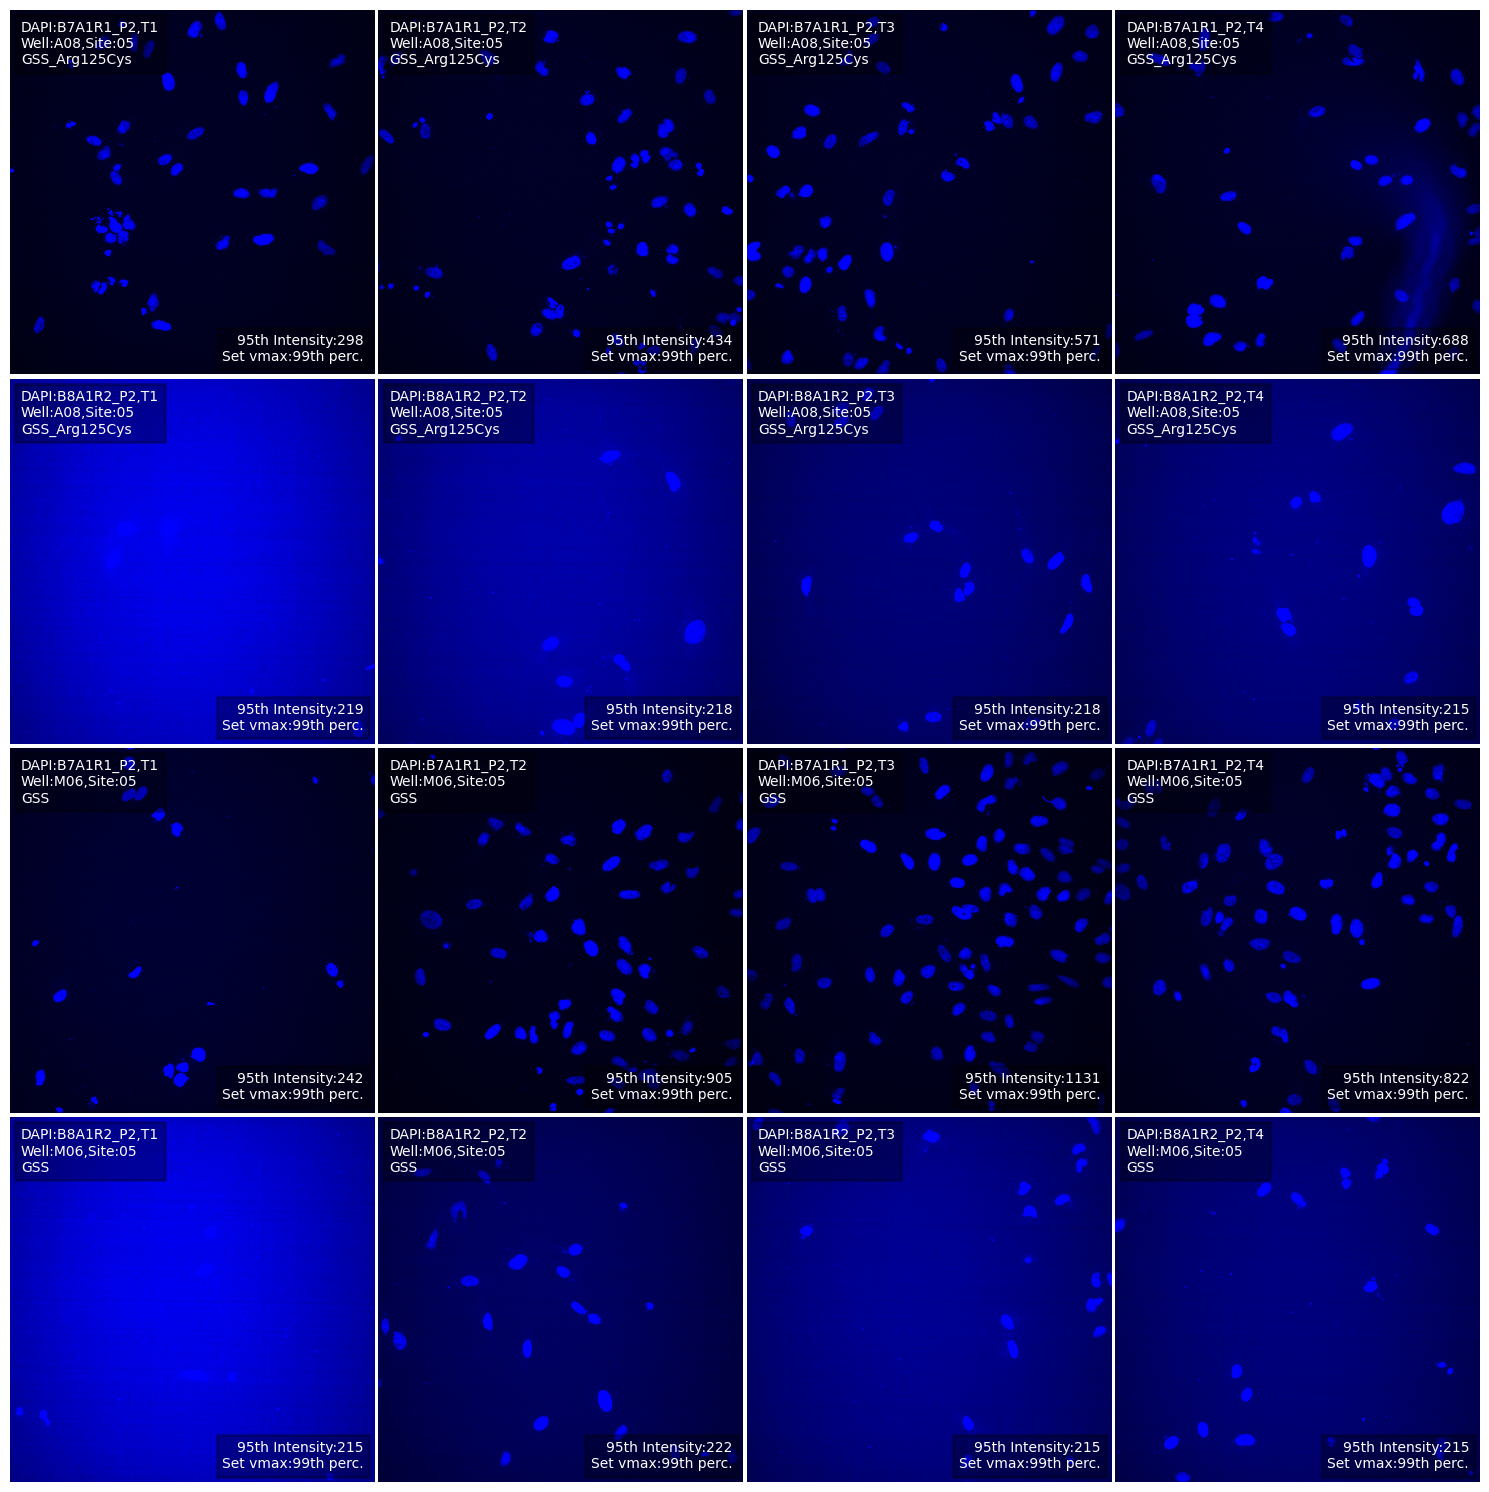

In [14]:
TIFF_IMGS_DIR = "../1.image_preprocess_qc/inputs/cpg_imgs"
OUT_IMGS_DIR = ""

## Manual visualization
### DES_Pro419Ser: drop B12
# plot_allele(allele_meta_df_dict["2024_01_Batch_7-8"], "DES_Pro419Ser", "DAPI", 
#             plate_img_qc=img_well_qc_sum_dict["2024_01_Batch_7-8"].with_columns(
#                 pl.col("channel").replace("DNA", "DAPI").alias("channel")
#             ), ref_well=["J21"], var_well=["L10"],
#             site="05", max_intensity=0.99, display=True, imgs_dir=TIFF_IMGS_DIR)
# plot_allele(allele_meta_df_dict["2024_01_Batch_7-8"], "DES_Pro419Ser", "DAPI", 
#             plate_img_qc=img_well_qc_sum_dict["2024_01_Batch_7-8"].with_columns(
#                 pl.col("channel").replace("DNA", "DAPI").alias("channel")
#             ), ref_well=["J21"], var_well=["B12"],
#             site="05", max_intensity=0.99, display=True, imgs_dir=TIFF_IMGS_DIR)

plot_allele(allele_meta_df_dict["2024_01_Batch_7-8"], "GSS_Arg125Cys", "DAPI", 
            plate_img_qc=img_well_qc_sum_dict["2024_01_Batch_7-8"].with_columns(
                pl.col("channel").replace("DNA", "DAPI").alias("channel")
            ),
            site="05", max_intensity=0.99, display=True, imgs_dir=TIFF_IMGS_DIR)

<Figure size 640x480 with 0 Axes>

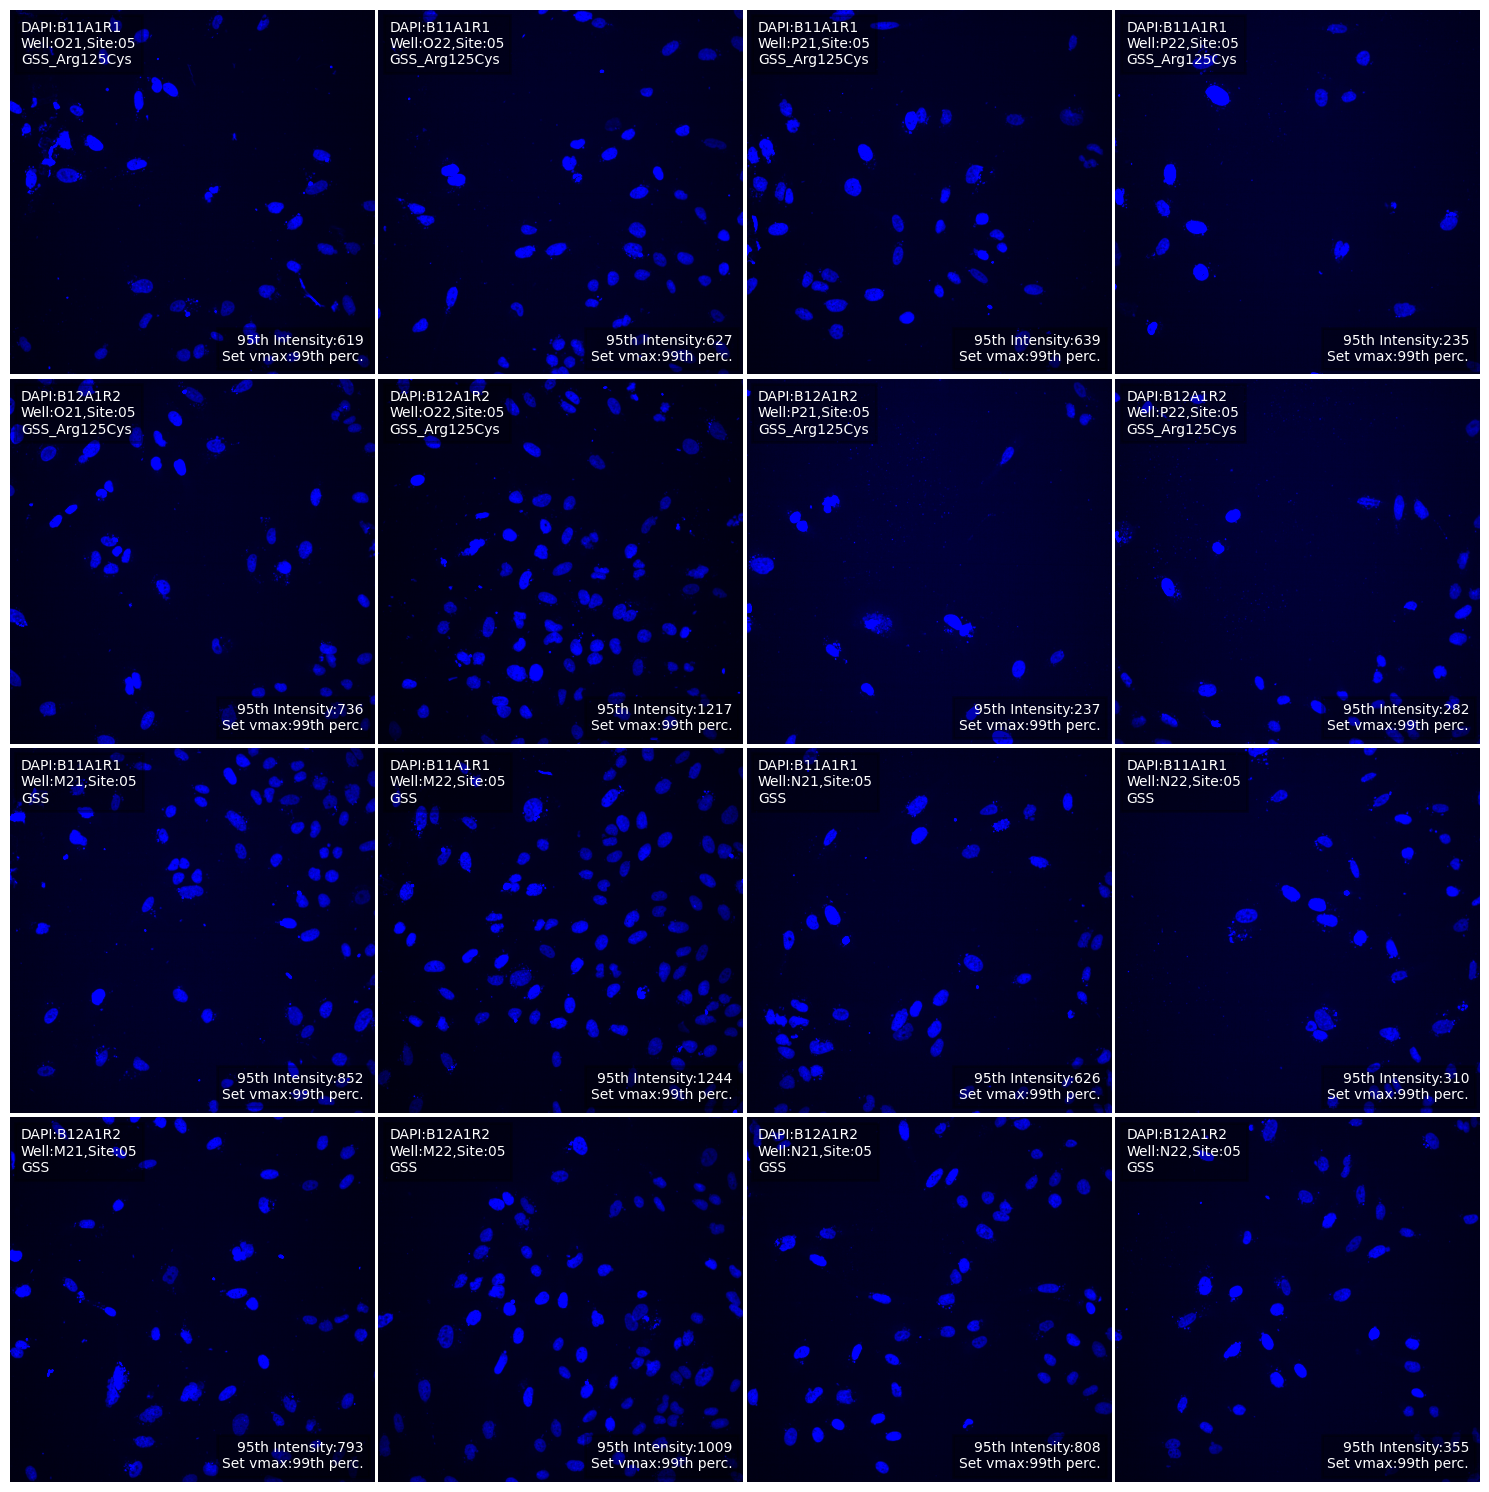

In [15]:
plot_allele_single_plate(allele_meta_df_dict["2024_12_Batch_11-12"], "GSS_Arg125Cys", "DAPI", 
            plate_img_qc=img_well_qc_sum_dict["2024_12_Batch_11-12"].with_columns(
                pl.col("channel").replace("DNA", "DAPI").alias("channel")
            ),
            site="05", max_intensity=0.99, display=True, imgs_dir=TIFF_IMGS_DIR)

In [16]:
well_cc_stats_final = pl.concat([
    well_cc_stats_rep,
    well_cc_stats_single.select(pl.col(well_cc_stats_rep.columns))
])

In [17]:
well_cc_stats_final

shape: (751, 4)
┌───────┬─────────────────┬─────────────┬─────────────┐
│ Gene  ┆ Variant         ┆ U2OS_t_stat ┆ U2OS_t_pval │
│ ---   ┆ ---             ┆ ---         ┆ ---         │
│ str   ┆ str             ┆ f64         ┆ f64         │
╞═══════╪═════════════════╪═════════════╪═════════════╡
│ GRN   ┆ GRN_Thr182Met   ┆ 1.263763    ┆ 0.260544    │
│ SMAD3 ┆ SMAD3_Thr261Ile ┆ 5.300672    ┆ 0.005691    │
│ GRN   ┆ GRN_Cys105Arg   ┆ 1.263763    ┆ 0.260544    │
│ SMAD3 ┆ SMAD3_Arg287Trp ┆ 8.493       ┆ 0.000979    │
│ AGXT  ┆ AGXT_Phe152Ile  ┆ 3.742812    ┆ 0.013212    │
│ …     ┆ …               ┆ …           ┆ …           │
│ KCNJ2 ┆ KCNJ2_Pro420Leu ┆ 7.768272    ┆ 0.000239    │
│ KCNJ2 ┆ KCNJ2_Cys76Gly  ┆ 1.8308e8    ┆ 3.8305e-56  │
│ KCNJ2 ┆ KCNJ2_Gly206Ser ┆ 5.316776    ┆ 0.012996    │
│ SMAD3 ┆ SMAD3_Pro124Leu ┆ 12.605938   ┆ 0.000015    │
│ FOXP3 ┆ FOXP3_Gly52Val  ┆ 2.645751    ┆ 0.033145    │
└───────┴─────────────────┴─────────────┴─────────────┘

In [18]:
# Total number of increase vs. decrease
total = well_cc_stats_final.shape[0]

## We are comparing REF - VAR in the paired_ttest ttest_rel
## The t-statistic is calculated as np.mean(a - b)/se, where se is the standard error.
## Thus, t-stat > 0 means REF more than VAR --> VAR decreasing CC
per_dec = well_cc_stats_final.filter(pl.col("U2OS_t_stat") > 0).shape[0]
per_inc = well_cc_stats_final.filter(pl.col("U2OS_t_stat") < 0).shape[0]

print("Total decreasin vs increasing percent:")
print(f"{per_dec}, {per_dec / total * 100:.2f} %")
print(f"{per_inc}, {per_inc / total * 100:.2f} %")

dec_sig = well_cc_stats_final.filter(pl.col("U2OS_t_pval") < 0.05).filter(pl.col("U2OS_t_stat") > 0).shape[0]
inc_sig = well_cc_stats_final.filter(pl.col("U2OS_t_pval") < 0.05).filter(pl.col("U2OS_t_stat") < 0).shape[0]

print("Number sig decreases")
print(f"{dec_sig}, {dec_sig / total * 100:.2f} %")
print("Number sig increases")
print(f"{inc_sig}, {inc_sig / total * 100:.2f} %")

Total decreasin vs increasing percent:
650, 86.55 %
101, 13.45 %
Number sig decreases
388, 51.66 %
Number sig increases
55, 7.32 %


In [19]:
well_cc_stats_final.write_csv(f"{CLASS_RES_OUTDIR}/well-level_cell-count_changes.csv")

## 4. Analyze wrt Clinvar Annotations

In [20]:
clin_var_annot_df = pl.read_csv("../../../../../../4_compare_AI_scores/3_outputs/varchamp_consolidated_alleles_clinvar_gnomad_dbnsfp_scores.tsv", 
                                separator="\t", infer_schema_length=10000)
clin_var_annot_df = clin_var_annot_df.with_columns(
    pl.concat_str([pl.col("symbol"), pl.col("aa_change")], separator="_").alias("gene_allele")
)
# allele_meta_df = allele_meta_df.join(
#     clin_var_annot_df.with_columns(
#         pl.concat_str([pl.col("symbol"), pl.col("aa_change")], separator="_").alias("gene_allele")
#     ),
#     on="gene_allele",
#     how="left"
# )
# allele_meta_df

In [21]:
well_cc_stats_final_clinvar = well_cc_stats_final.join(
    clin_var_annot_df.select(pl.col(["gene_allele", "clinvar_clnsig_clean_dbnsfp"])), 
    left_on="Variant",
    right_on="gene_allele",
    how="inner"
).with_columns(
    (np.sign(pl.col("U2OS_t_stat")) * np.log10(abs(pl.col("U2OS_t_stat")))).alias("-log10(t-stats)")
).drop_nulls(subset="clinvar_clnsig_clean_dbnsfp")

<Figure size 640x480 with 0 Axes>

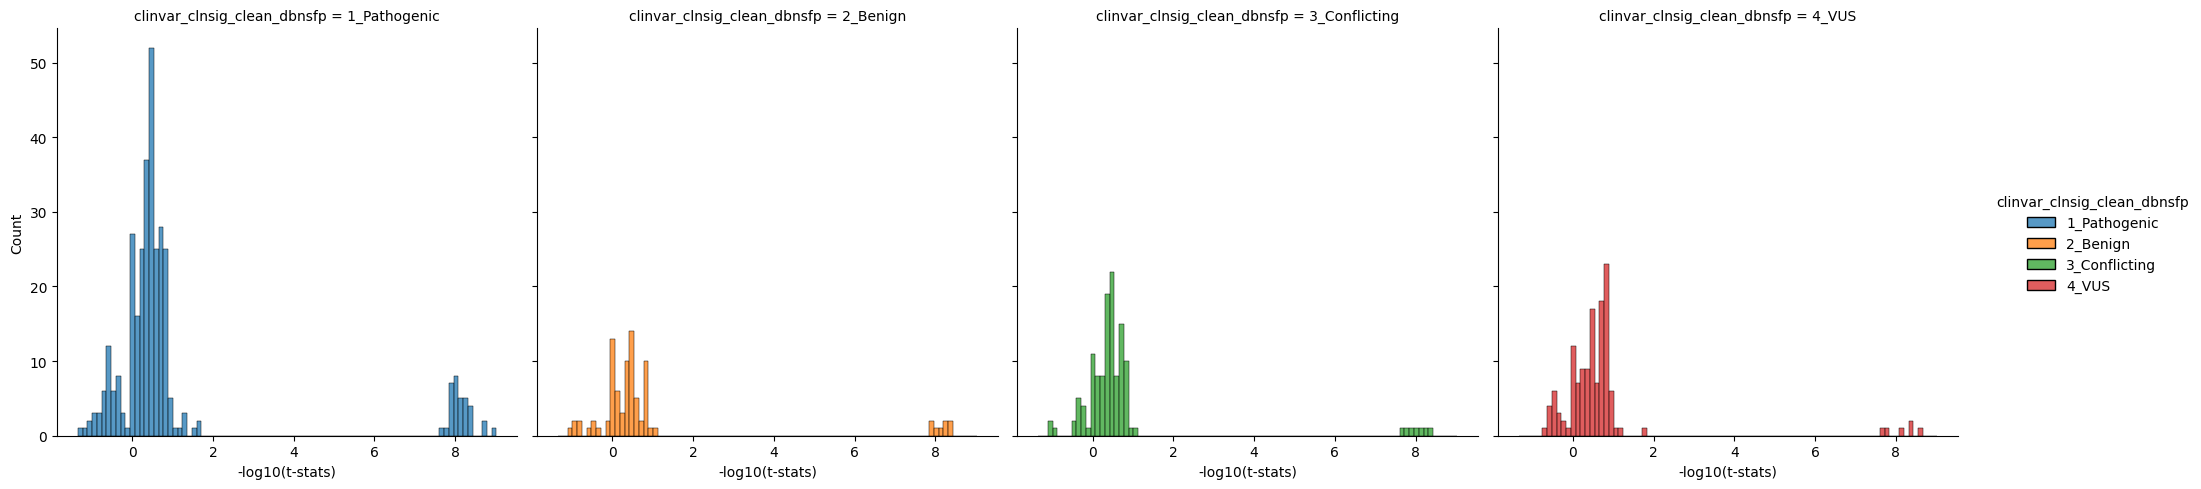

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.clf()
sns.displot(
    data=well_cc_stats_final_clinvar.filter(pl.col("clinvar_clnsig_clean_dbnsfp")!="5_Others").to_pandas().sort_values("clinvar_clnsig_clean_dbnsfp"),
    x="-log10(t-stats)",
    hue="clinvar_clnsig_clean_dbnsfp",
    col="clinvar_clnsig_clean_dbnsfp",
    col_order=['1_Pathogenic', '2_Benign', '3_Conflicting', '4_VUS'],
    hue_order=['1_Pathogenic', '2_Benign', '3_Conflicting', '4_VUS'],
)
plt.show()